### Import Libraries

In [4]:
import sys
sys.path.insert(1, '../scripts')
import extended_model
import importlib
import glob
import json
importlib.reload(extended_model)

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import bisect

import itertools
from functools import reduce
from operator import mul
from scipy.stats import norm
import random
from math import comb

import multiprocessing as mp

from tqdm import tqdm

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14

### Run the simulation

In [5]:
pool = mp.Pool(processes=32)

simulation_count = 100
n_nodes = 4
N = 100
p = .2
params = [*zip([*range(simulation_count)], [n_nodes]*simulation_count, [N]*simulation_count, [p]*simulation_count)]

results = pool.starmap(extended_model.simulate, params)
results = {k:v for k,v in results}

 19%|█▉        | 13661/72001 [00:03<00:14, 3991.51it/s]

 19%|█▉        | 13880/72001 [00:03<00:15, 3844.92it/s]

 30%|███       | 21860/72001 [00:05<00:12, 4120.93it/s]


# Analysis

## Only One Simulation 

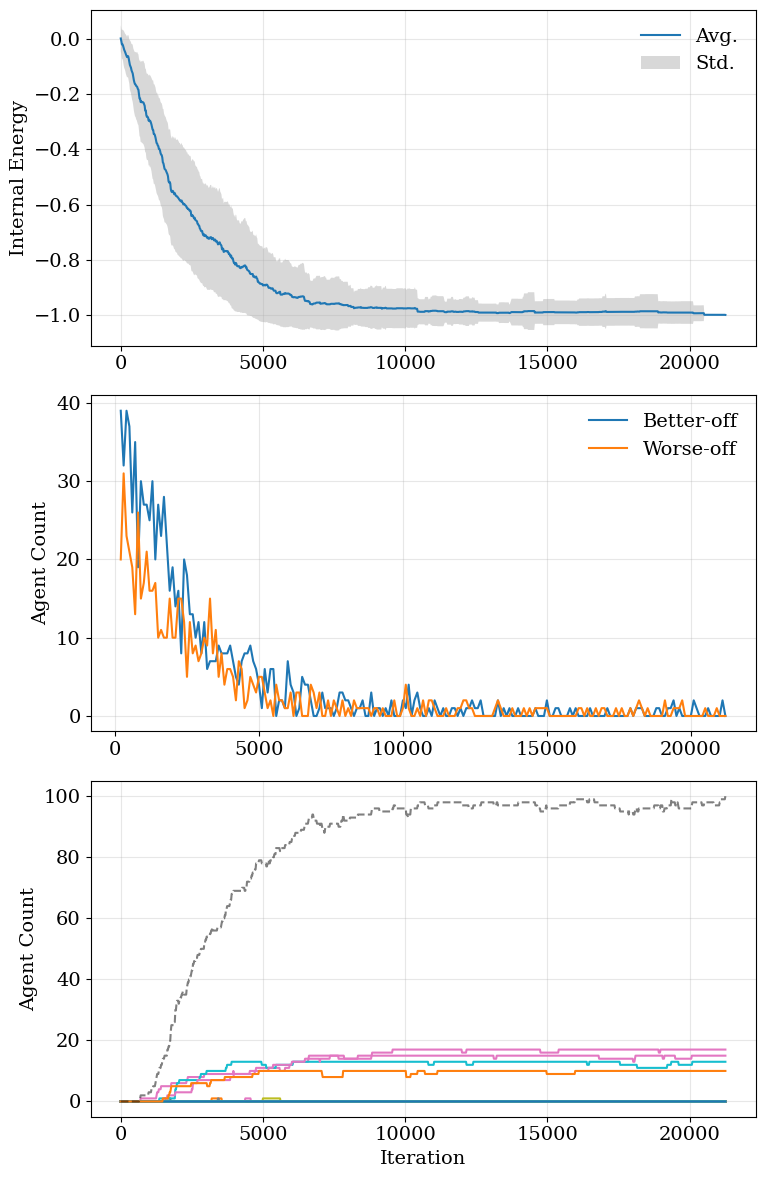

In [7]:
i = 15
track = results[i]

types_of_stable = extended_model.permute_stable_networks(n_nodes)

fig, axs = plt.subplots(3,1,figsize=(8,12))
mean_values = np.array([np.mean(v['internal_energies']) for v in track.values()])
std_values = np.array([np.std(v['internal_energies']) for v in track.values()])/2

x = [*track.keys()]

axs[0].plot(x, mean_values, label = 'Avg.')
axs[0].fill_between(x, mean_values-std_values, mean_values+std_values, facecolor='gray', alpha=0.3, label = 'Std.')

for sign, label in zip([-1,1], ['Better-off', 'Worse-off']):
    axs[1].plot([k for k,v in track.items() if 'better_off' in v.keys()],
                [sum(v['better_off']==sign) for k,v in track.items() if 'better_off' in v.keys()],
                label=label,
                )

# Plot the number of stable agents
for stable in types_of_stable:
    axs[2].plot(x,
                [sum([all(b==stable) for b in v['beliefs']]) for v in track.values()],
                label=", ".join([str(i) for i in list(stable)]),
                )
axs[2].plot(x,
            [sum(v['internal_energies']==-1) for k,v in track.items()],
            label='Total Stable',
            color='black',
            linestyle='--',
            alpha=.5)

for i, ylabel in zip([0, 1, 2], ['Internal Energy', 'Agent Count', 'Agent Count']):
    axs[i].grid(alpha=.3)
    axs[i].set_ylabel(ylabel)
    
    if i != 2:
        axs[i].legend(frameon=False)

axs[2].set_xlabel('Iteration')

fig.tight_layout()
fig.show()

In [13]:
[v['beliefs'] for v in track.values()][-1]

array([[-1, -1, -1,  1,  1,  1],
       [-1, -1,  1,  1, -1, -1],
       [ 1,  1, -1,  1, -1, -1],
       [ 1, -1, -1, -1, -1,  1],
       [ 1, -1, -1, -1, -1,  1],
       [ 1, -1, -1, -1, -1,  1],
       [-1, -1,  1,  1, -1, -1],
       [-1, -1,  1,  1, -1, -1],
       [ 1, -1, -1, -1, -1,  1],
       [-1,  1,  1, -1, -1,  1],
       [-1, -1, -1,  1,  1,  1],
       [-1, -1,  1,  1, -1, -1],
       [ 1,  1, -1,  1, -1, -1],
       [-1, -1, -1,  1,  1,  1],
       [ 1, -1, -1, -1, -1,  1],
       [-1, -1,  1,  1, -1, -1],
       [-1,  1,  1, -1, -1,  1],
       [-1,  1, -1, -1,  1, -1],
       [-1,  1,  1, -1, -1,  1],
       [ 1, -1, -1, -1, -1,  1],
       [-1, -1,  1,  1, -1, -1],
       [ 1,  1,  1,  1,  1,  1],
       [ 1, -1, -1, -1, -1,  1],
       [ 1,  1, -1,  1, -1, -1],
       [-1,  1, -1, -1,  1, -1],
       [ 1,  1, -1,  1, -1, -1],
       [ 1,  1,  1,  1,  1,  1],
       [-1,  1, -1, -1,  1, -1],
       [ 1,  1,  1,  1,  1,  1],
       [-1,  1, -1, -1,  1, -1],
       [ 1

## All Simulations Together

### Run the analyses

In [ ]:
internal_energy_analysis_data_sum = extended_model.internal_energy_analysis(results)
better_off_worse_off_data_sum = extended_model.better_off_worse_off_analysis(results)
stability_analysis_data = extended_model.stability_analysis(results, n_nodes = n_nodes)

### Save the results

In [ ]:
temp = internal_energy_analysis_data_sum.copy()
for _ in ['avg', 'upper', 'lower']:
    temp[_] = temp[_].tolist()

with open('../data/internal_energy_analysis_data_sum.json', 'w') as f:
    json.dump(temp, f)

In [ ]:
temp = better_off_worse_off_data_sum.copy()
for c in ['better_off', 'worse_off']:
    for _ in ['avg', 'upper', 'lower']:
        temp[c][_] = temp[c][_].tolist()

with open('../data/better_off_worse_off_data_sum.json', 'w') as f:
    json.dump(temp, f)

In [ ]:
with open('../data/stability_analysis_data.json', 'w') as f:
    json.dump(stability_analysis_data, f, default=float)

### Visualize

In [ ]:
fig, axs = plt.subplots(3,1,figsize=(8,12))

for i, d, l in zip([0,1,1,2,2,2,2], 
                [internal_energy_analysis_data_sum, better_off_worse_off_data_sum['better_off'], better_off_worse_off_data_sum['worse_off'],
                stability_analysis_data_sum[0], stability_analysis_data_sum[1], stability_analysis_data_sum[2], stability_analysis_data_sum[3]],
                ['Avg.','Better-off', 'Worse-off','Stable 1','Stable 2','Stable 3','Stable 4']):

    x = [i*20 for i in d['x']] if (l != 'Better-off') & (l != 'Worse-off') else d['x']

    axs[i].plot(x,
                d['avg'],
                label=l)
    axs[i].fill_between(x, d['lower'], d['upper'], alpha=.3, label = '95% Interval')

for i,l in zip([0,1,2], ['Internal Energy', 'Agent Count', 'Agent Count']):
    axs[i].grid(alpha=.3)
    axs[i].set_ylabel(l)
    axs[i].legend(frameon=False)

axs[i].set_xlabel('Iteration')

fig.tight_layout()
fig.show()